### automl efficientdet 다운로드 및 설치

In [ ]:
!git clone --depth 1 https://github.com/google/automl


In [ ]:
!cd /content/automl/efficientdet; pip install -r requirements.txt

In [ ]:
!pip uninstall -y keras

In [ ]:
!nvidia-smi

In [ ]:
import os
import sys
import tensorflow.compat.v1 as tf

sys.path.append('/content/automl/efficientdet')

import hparams_config
from keras import anchors
from model_inspect import ModelInspector

### ESRI Object Detection Challenge Dataset 다운로드 및 파일 살펴 보기
* Annotation은 PASCAL VOC 와 동일한 XML 포맷

In [ ]:
!mkdir -p /content/poolncar
!wget https://github.com/chulminkw/DLCV/releases/download/1.0/swimming_pool_and_car.zip
!unzip swimming_pool_and_car.zip -d /content/poolncar > /dev/null 2>&1

In [ ]:
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import math

CLASSES = ['1','2']

# XML 파일을 Pandas DataFrame으로 변환 한뒤 DataFrame의 to_csv()를 이용하여 csv 파일로 생성하고 DataFrame반환
def get_bboxes_from_xml(xml_file):
  # xml 파일을 parsing하여 XML Element형태의 Element Tree를 생성하여 object 정보를 추출. 
  tree = ET.parse(xml_file)
  root = tree.getroot()
  bboxes = []
  bbox_names = []

  if root.iter('object') is not None:
    for obj in root.iter('object'):
      bbox_name = obj.find('name').text
      if bbox_name not in CLASSES:
          continue

      xmlbox = obj.find('bndbox')
      # 위치 좌표가 소수점까지 표시됨. pixel 단위는 정수형이므로 변환하되 ceil로 조금 이동하여 변환
      x1 = math.ceil(float(xmlbox.find('xmin').text))
      y1 = math.ceil(float(xmlbox.find('ymin').text))
      x2 = math.ceil(float(xmlbox.find('xmax').text))
      y2 = math.ceil(float(xmlbox.find('ymax').text))
      if x1 == x2 or y1 == y2:
          continue
      bbox = [x1, y1, x2, y2]
      bboxes.append(bbox)
      bbox_names.append(bbox_name) 
    
  return bbox_names, bboxes

bbox_names, bboxes = get_bboxes_from_xml('/content/poolncar/training_data/training_data/labels/000000000.xml')
print('object별 class 명:', bbox_names)
print('object별 bbox 정보 list:', bboxes)

In [ ]:
import matplotlib.pyplot as plt
import cv2

img_rgb = cv2.cvtColor(cv2.imread('/content/poolncar/training_data/training_data/images/000000002.jpg'), cv2.COLOR_BGR2RGB)

bbox_names, bboxes = get_bboxes_from_xml('/content/poolncar/training_data/training_data/labels/000000002.xml')
for box_name, box in zip(bbox_names, bboxes):
  cv2.rectangle(img_rgb, (box[0], box[1]), (box[2], box[3]), color=(0, 255, 0), thickness=1)
  cv2.putText(img_rgb, box_name, (int(box[0]), int(box[1] - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [ ]:
import os
ANNO_DIR = '/content/poolncar/training_data/training_data/labels'
file_list = os.listdir(ANNO_DIR)
xml_files = sorted([file for file in file_list if file.endswith('.xml')])
print('xml file list:', xml_files)
print('xml file 개수:', len(xml_files))

### 개별 XML 정보와 이미지를 tf.train.Example로 변경하는 함수 생성. 
* https://github.com/google/automl/blob/master/efficientdet/dataset/create_pascal_tfrecord.py 참조

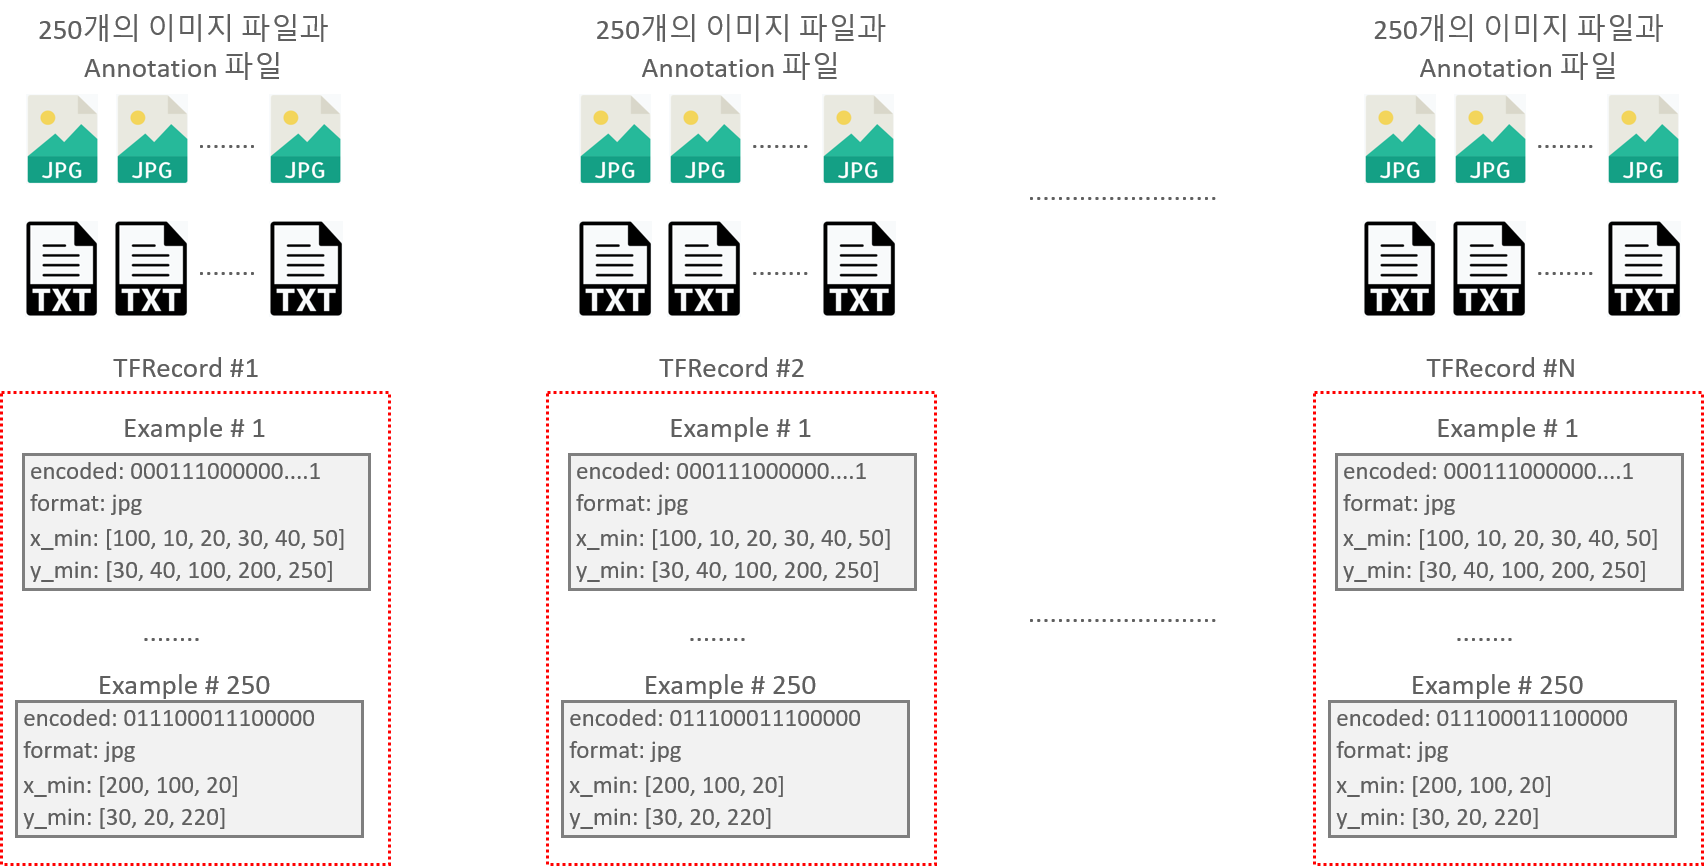

In [ ]:
import xml.etree.ElementTree as ET

# xml 을 파싱해서 image와 object의 메타정보를 dict로 반환하는 함수 
def get_anno_dict_from_xml(xml_filepath):
  tree = ET.parse(xml_filepath)
  root = tree.getroot()
  bbox_names = []
  objects = []

  filename = root.find('filename').text
  size = root.find('size')
  width = int(size.find('width').text)
  height = int(size.find('height').text)

  # 파일내에 있는 모든 object Element를 찾음. 
  for obj in root.findall('object'):
    name = obj.find('name').text
    pose = 'Unspecified'
    #truncated, poses, difficult_obj는 사용되지 않지만 create_pascal_voc.py 파일과의 호환성을 유지하기 위해 설정. 
    truncated = 0
    difficult = 0
    occluded = 0

    #pose = obj.find('pose').text
    #truncated = int(obj.find('truncated').text)
    #difficult = int(obj.find('difficult').text)
    #occluded = int(obj.find('occluded').text)

    xmlbox = obj.find('bndbox')
    # 위치 좌표가 소수점까지 표시됨. pixel 단위는 정수형이므로 변환하되 ceil로 조금 이동하여 변환
    xmin = math.ceil(float(xmlbox.find('xmin').text))
    ymin = math.ceil(float(xmlbox.find('ymin').text))
    xmax = math.ceil(float(xmlbox.find('xmax').text))
    ymax = math.ceil(float(xmlbox.find('ymax').text))
    bbox = {
        'xmin': xmin, 
        'ymin': ymin, 
        'xmax': xmax, 
        'ymax': ymax
        }
    
    single_obj = {'name':name, 'pose':pose, 'truncated':truncated, 'difficult':difficult, 'occluded':occluded,
              'bndbox':bbox}
    objects.append(single_obj)

  anno_dict = {
      'folder':'training_data', 'filename':filename, 'width':width, 'height':height,
      'object':objects
  }

  return anno_dict

In [ ]:
anno_dict = get_anno_dict_from_xml('/content/poolncar/training_data/training_data/labels/000000000.xml')
anno_dict

In [ ]:
# image와 object의 고유 id 부여. 
class Unique_Id(object):
  
  def __init__(self):
    self.image_id = 0
    self.ann_id = 0

  def get_image_id(self):
    self.image_id += 1
    return self.image_id

  def get_ann_id(self):
    self.ann_id += 1
    return self.ann_id


In [ ]:
# https://github.com/google/automl/blob/master/efficientdet/dataset/create_pascal_tfrecord.py 참조

import hashlib
import io
import json
import os
import PIL.Image
import tensorflow as tf
from dataset import tfrecord_util

# 1개의 image 파일 PATH와 1개의 annotation XML 정보를 가지는 data dic를 이용하여 tf.train.Example를 생성. 
def dict_to_tf_example(data, image_path, label_map_dict, unique_id, ignore_difficult_instances=False, ann_json_dict=None, debug=True):
  ''' 
    data는  1개의 xml 파일을 dictionary로 변환 anno_dict,
    image는 1개의 xml에 매핑되는 image 파일의 절대 경로
    unique_id는 고유한 image와 object id를 만들기 위한 Unique_Id객체
  ''' 
  
  #JPEG image를 binary 그대로 읽음. 
  with tf.io.gfile.GFile(image_path, 'rb') as fid:
    encoded_jpg = fid.read()
  
  # image가 JPEG 타입인지 확인. 
  encoded_jpg_io = io.BytesIO(encoded_jpg)
  image = PIL.Image.open(encoded_jpg_io)
  if image.format != 'JPEG':
    raise ValueError('Image format not JPEG')
  
  # image의 고유 key값 생성. 
  key = hashlib.sha256(encoded_jpg).hexdigest()

  #고유한 image id를 생성. 
  image_id = unique_id.get_image_id()
  # image의 width와 height 가져옴. 
  width = data['width']
  height = data['height']
 
  xmins, ymins, xmaxes, ymaxes = [], [], [], []
  areas, classes, classes_texts = [], [], []
  truncated, poses, difficult_obj = [], [], []
  # 만일 annotation에 1개 이상의 object가 있다면, 
  if 'object' in data:
    # data(anno_dict)의 'object' key값으로 개별 object 별 annotation 정보를 dict로 가지는 list로 구성. 이 list를 iteration 수행. 
    for obj in data['object']:
      difficult = bool(int(obj['difficult']))
      if ignore_difficult_instances and difficult:
        continue
      # object 명이 '1', '2'가 아니면 제외. 
      if obj['name'] not in label_map_dict:
        continue

      difficult_obj.append(int(difficult))
      # 개별 좌표 값을 이미지의 크기로 정규화하고 list로 저장. 
      xmins.append(float(obj['bndbox']['xmin']) / width)
      ymins.append(float(obj['bndbox']['ymin']) / height)
      xmaxes.append(float(obj['bndbox']['xmax']) / width)
      ymaxes.append(float(obj['bndbox']['ymax']) / height)
      areas.append((xmaxes[-1] - xmins[-1]) * (ymaxes[-1] - ymins[-1]))
      # class명과 class_id를 list로 저장. 
      classes_texts.append(obj['name'].encode('utf8'))
      classes.append(label_map_dict[obj['name']])
      # truncated, poses, difficult_obj는 사용되지 않지만 create_pascal_voc.py 파일과의 호환성을 유지하기 위해 저장. 
      truncated.append(int(obj['truncated']))
      poses.append(obj['pose'].encode('utf8'))
      difficult_obj.append(obj['difficult'])

  example_dict = {'height':height, 'width':width, 'filename':data['filename'].encode('utf8'),
                  'source_id': str(image_id).encode('utf8'), 'key_sha256': key.encode('utf8'),
                  'encoded': encoded_jpg, 'format':'jpeg'.encode('utf8'),
                  'xmin':xmins, 'xmax':xmaxes, 'ymin':ymins, 'ymax':ymaxes,
                  'area':areas, 'class_text':classes_texts, 'class_label':classes,
                  'difficult':difficult_obj, 'truncated':truncated, 'poses':poses}
  if debug:
   print('example_dict:', example_dict) 

  example = make_tfrecord_example(example_dict)

  return example

In [ ]:
import tensorflow as tf
from dataset import tfrecord_util

# 인자로 들어온 dict에 따라 tf.train.Example을 생성. 
def make_tfrecord_example(example_dict):
  example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image/height': tfrecord_util.int64_feature(example_dict['height']),
                'image/width': tfrecord_util.int64_feature(example_dict['width']),
                'image/filename': tfrecord_util.bytes_feature(example_dict['filename']),
                'image/source_id': tfrecord_util.bytes_feature(example_dict['source_id']),
                'image/key/sha256': tfrecord_util.bytes_feature(example_dict['key_sha256']),
                'image/encoded': tfrecord_util.bytes_feature(example_dict['encoded']),
                'image/format': tfrecord_util.bytes_feature('jpeg'.encode('utf8')),
                'image/object/bbox/xmin': tfrecord_util.float_list_feature(example_dict['xmin']),
                'image/object/bbox/xmax': tfrecord_util.float_list_feature(example_dict['xmax']),
                'image/object/bbox/ymin': tfrecord_util.float_list_feature(example_dict['ymin']),
                'image/object/bbox/ymax': tfrecord_util.float_list_feature(example_dict['ymax']),
                'image/object/area': tfrecord_util.float_list_feature(example_dict['area']),
                'image/object/class/text': tfrecord_util.bytes_list_feature(example_dict['class_text']),
                'image/object/class/label': tfrecord_util.int64_list_feature(example_dict['class_label']),
                'image/object/difficult': tfrecord_util.int64_list_feature(example_dict['difficult']),
                'image/object/truncated': tfrecord_util.int64_list_feature(example_dict['truncated']),
                'image/object/view': tfrecord_util.bytes_list_feature(example_dict['poses']),
            }))
  
  return example


In [ ]:
label_map_dict = {
    '1': 1,
    '2': 2
}

# 테스트 용도로 한개의 Example 생성해 보기 
unique_id = Unique_Id()
data = get_anno_dict_from_xml('/content/poolncar/training_data/training_data/labels/000000000.xml')
print('## xml 파일을 data dic로 변경 결과:', data)
image_path = '/content/poolncar/training_data/training_data/images/000000000.jpg'

example = dict_to_tf_example(data, image_path, label_map_dict, unique_id, ignore_difficult_instances=False, ann_json_dict=None)

In [ ]:
example

### 학습과 검증용 TFRecord 파일들을 생성. 
* 학습과 검증용 DataFrame으로 학습, 검증 데이터세트 분류
* 개별 Example을 생성하는 dict_to_tf_example()을 이용하여 모든 데이터 세트를 TFRecord로 생성. 

In [ ]:
file_id_list = sorted([xml_file[:xml_file.rfind('.xml')] for xml_file in os.listdir('/content/poolncar/training_data/training_data/labels') \
                if '.xml' in xml_file])
print(file_id_list)
len(file_id_list)

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', 300)
data_df = pd.DataFrame({'file_id': file_id_list})
data_df['image_path'] = '/content/poolncar/training_data/training_data/images/' + data_df['file_id'] + '.jpg'
data_df['xml_path'] = '/content/poolncar/training_data/training_data/labels/' + data_df['file_id'] + '.xml'

print(data_df.shape)
data_df.head()

In [ ]:
from sklearn.model_selection import train_test_split

# 전체 데이터의 20%를 검증용으로 할당. 
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=2021)
print(train_df.shape, val_df.shape)

In [ ]:
# 모든 image/xml 파일들을 TFRecord로 생성. 
def make_tfrecords(meta_df, output_dir, output_prefix, num_shards):
  '''
  meta_df: train/val DataFrame에서 입력 xml과 image의 경로를 가져옴. 
  output_dir: 출력 TFRecord가 저장될 directory
  output_prefix: 출력 TFRecord 파일의 prefix명. 
  num_shards: 만들어질 TFRecord 파일의 수
  '''
  xml_list = meta_df['xml_path'].to_list()
  image_list = meta_df['image_path'].to_list()

  unique_id = Unique_Id()
  # num_shards 만큼의 TFRecordWriter객체 생성. 
  writers = [
        tf.io.TFRecordWriter(output_dir + output_prefix +'-%05d-of-%05d.tfrecord' %
                            (i, num_shards))
        for i in range(num_shards)
    ]
  #xml 개수만큼 iteration을 돌려서 Example을 만들고 개별 Example을 특정 shard에 해당하는 TFRecord에 append
  for idx, xml_path in enumerate(xml_list):
    if idx % 100 == 0:
      print('On image ', idx, 'of ', len(xml_list))
    
    data = get_anno_dict_from_xml(xml_path)
    image_path = image_list[idx]
    # 개별 Example 생성. 
    tf_example = dict_to_tf_example(data, image_path, label_map_dict, unique_id, 
                                    ignore_difficult_instances=False, ann_json_dict=None, debug=False)
    # num_shard만큼 만들어진 TFRecord에 Example을 iteration을 수행하면서 해당하는 TFRecord로 append 
    writers[idx % num_shards].write(tf_example.SerializeToString())
  
  # num_shards 만큼 만들어진 TFRecordWriter 객체 close
  for writer in writers:
    writer.close()

In [ ]:
!mkdir -p /content/tfrecord/train
!mkdir -p /content/tfrecord/val

In [ ]:
print('#### train용 tfrecords 생성 시작 ####')
make_tfrecords(train_df, '/content/tfrecord/train/', 'train', num_shards=100)

print('#### val용 tfrecords 생성 시작 ####')
make_tfrecords(val_df, '/content/tfrecord/val/', 'val', num_shards=100)

In [ ]:
!ls -lia /content/tfrecord/train
!ls -lia /content/tfrecord/val

### Pretrained 모델을 다운로드 받고 Train을 위한 config 생성
* pretrained 모델은 efficientdet-d2
* num_classes는 2, max_instances_per_image는 기본 100개임. 1개의 이미지에  특정 object의 갯수가 100개를 초과하는 경우가 있음.  max_instances_per_image = 200 으로 수정. 

In [ ]:
# epochs시마다 학습된 weight파일을 저장한 디렉토리 Google drive로 설정. 
# Google Drive 접근을 위한 Mount 적용. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

# soft link로 Google Drive Directory 연결. 
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive
!mkdir -p /mydrive/model_trained_d2

In [ ]:
MODEL = 'efficientdet-d2' 

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

In [ ]:
class TRAIN_CFG:
  model_name = 'efficientdet-d2' # efficientdet 모델명
  strategy = '' # tpu, 여러개의 GPU들, 단일 GPU 일때 학습 strategy 설정. 
  model_dir = '/mydrive/model_trained_d2' # 학습된 모델이 저장될 위치
  pretrained_ckpt = '/content/efficientdet-d2' # coco로 pretrained된 checkpoint 파일이 있는 디렉토리 위치
  # num_classes는 2개임. 
  hparams = 'num_classes=2,moving_average_decay=0,mixed_precision=true'
  use_xla = False
  use_fake_data = False
  # max_instances_per_image를 200으로 설정하고, D2 모델이 상대적으로 더 크기 때문에 batch_size를 8로 설정시 GPU Out of Memory 발생 
  batch_size = 4
  eval_samples = 5000 # evaluation image 데이터 갯수
  steps_per_execution = 1 # train 시 steps 횟수
  num_examples_per_epoch = 3000 # 1 epochs 시 적용하는 examples 개수 
  num_epochs = 20 # epochs 횟수
  train_file_pattern = '/content/tfrecord/train/train-*.tfrecord' # 학습용 tfrecords를 glob 형태로 가져오는 표현식. 
  val_file_pattern = '/content/tfrecord/val/val-*.tfrecord' # 검증용 tfrecords를 glob 형태로 가져오는 표현식. 
  val_json_file = None # optional coco validation json 
  mode = 'traineval' # train만 적용 또는 train과 eval함께 적용(traineval)
  num_shards = 100 # 
  # max_instances_per_image는 기본 100개임. 1개의 이미지에  특정 object의 갯수가 100개를 초과하는 경우가 있음. 200으로 수정. 
  max_instances_per_image = 200
  
  num_cores = 2 # tpu 일때 8 적용.  
  tpu = None
  gcp_project = None
  tpu_zone = None
  eval_master = ''
  eval_name = None
  tf_random_seed = 2021
  profile = False
  debug = False

In [ ]:
from keras.train import setup_model
import hparams_config

import utils
from keras import tfmot
from keras import train_lib
from keras import util_keras

config = hparams_config.get_detection_config(TRAIN_CFG.model_name)
config.override(TRAIN_CFG.hparams)

steps_per_epoch = TRAIN_CFG.num_examples_per_epoch // TRAIN_CFG.batch_size

if tf.config.list_physical_devices('GPU'):
  ds_strategy = tf.distribute.OneDeviceStrategy('device:GPU:0')
else:
  ds_strategy = tf.distribute.OneDeviceStrategy('device:CPU:0')

print(ds_strategy)

params = dict(
      profile=TRAIN_CFG.profile,
      mode = TRAIN_CFG.mode,
      model_name=TRAIN_CFG.model_name,
      steps_per_execution=TRAIN_CFG.steps_per_execution,
      num_epochs = TRAIN_CFG.num_epochs,
      model_dir=TRAIN_CFG.model_dir,
      steps_per_epoch=steps_per_epoch,
      strategy=TRAIN_CFG.strategy,
      batch_size=TRAIN_CFG.batch_size,
      tf_random_seed=TRAIN_CFG.tf_random_seed,
      debug=TRAIN_CFG.debug,
      val_json_file=TRAIN_CFG.val_json_file,
      eval_samples=TRAIN_CFG.eval_samples,
      num_shards=ds_strategy.num_replicas_in_sync,
      # max_instances_per_image는 기본 100개임. 1개의 이미지에  특정 object의 갯수가 100개를 초과하는 경우가 있음. 200으로 수정.
      max_instances_per_image = TRAIN_CFG.max_instances_per_image
      )

config.override(params, True)

# image size를 tuple 형태로 변환. 512는 (512, 512)로 '1920x880' 은 (1920, 880) 으로 변환.  
config.image_size = utils.parse_image_size(config.image_size)
print(config)

In [ ]:
import utils
from keras import tfmot
from keras import train_lib
from keras import util_keras
# P100에서는 적용할 필요 없음. 
'''
precision = utils.get_precision(config.strategy, config.mixed_precision)
policy = tf.keras.mixed_precision.Policy(precision)
tf.keras.mixed_precision.set_global_policy(policy)
'''

### Dataset과 Model 생성하고 학습 수행. 
* 앞에서 만든 train과 val용 TFRecord를 이용하여 dataloader.InputReader를 생성하는 함수 생성.
* efficientdet-d2 모델 생성 후 pretrained 모델의 weight 전이.
* batch_size 4로 설정. 8로 설정 시 GPU Memory OOM 발생 가능성 높음(Out Of Memory), epochs 20으로 학습 수행. 

In [ ]:
import dataloader

def get_dataset(is_training, config):
  # is_training이 True이면 TRAIN_CFG의 train_file_pattern, 그렇지 아니면 val_file_pattern
  file_pattern = (
    TRAIN_CFG.train_file_pattern
    if is_training else TRAIN_CFG.val_file_pattern)
  if not file_pattern:
    raise ValueError('No matching files.')

  return dataloader.InputReader(
    file_pattern,
    is_training=is_training,
    use_fake_data=TRAIN_CFG.use_fake_data,
    max_instances_per_image=config.max_instances_per_image,
    debug=TRAIN_CFG.debug)(
        config.as_dict())

In [ ]:
from keras import train_lib
from keras import train

def get_efficientdet_model(config):
  # 2개의 class를 가진 efficientdet d2 모델을 생성. 
  model = train_lib.EfficientDetNetTrain(config=config)
  model = train.setup_model(model, config)
  # 만약 pretrained 모델이 있으면, 해당 checkpoint weight를 모델로 로딩. 이때 classification layer는 제외. 
  #class TRAIN_CFG: pretrained_ckpt = '/content/efficientdet-d2' 
  if TRAIN_CFG.pretrained_ckpt:
    ckpt_path = tf.train.latest_checkpoint(TRAIN_CFG.pretrained_ckpt)
    # classfication layer를 제외하고 pretrained weight를 생성된 모델로 로딩. 
    util_keras.restore_ckpt(
        model,
        ckpt_path,
        config.moving_average_decay,
        exclude_layers=['class_net'])
    
  train.init_experimental(config)
  return model

model = get_efficientdet_model(config)
model.summary()

In [ ]:
print(config.mode)

In [ ]:
from keras import train
import numpy as np

config.batch_size = 4
tr_steps_per_epoch = train_df.shape[0]//config.batch_size
val_steps_per_epoch = val_df.shape[0]//config.batch_size
print('tr_steps_per_epoch:', tr_steps_per_epoch, 'val_steps_per_epoch:', val_steps_per_epoch)

val_dataset = get_dataset(False, config) if 'eval' in config.mode else None
model.fit(
    get_dataset(True, config),
    epochs=20,
    steps_per_epoch=tr_steps_per_epoch,
    callbacks=train_lib.get_callbacks(config.as_dict(), val_dataset),
    validation_data=val_dataset,
    validation_steps=val_steps_per_epoch)

tf.keras.backend.clear_session()

### 학습된 모델 파일을 이용하여 Inference 수행.

In [ ]:
import sys

sys.path.append('/content/automl/efficientdet')

In [ ]:
import hparams_config

infer_config = hparams_config.get_efficientdet_config('efficientdet-d2')

# config의 특정 항목을 update
infer_config.model_name = 'efficientdet-d2'
infer_config.model_dir = '/mydrive/model_trained_d2'
# infer_config의 num_classes는 2로 바뀌어야 함. 
infer_config.num_classes = 2
infer_config.is_training_bn = False
infer_config.nms_configs.score_thresh = 0.4

print(infer_config)

In [ ]:
import inference
from keras import efficientdet_keras
import tensorflow as tf

model = efficientdet_keras.EfficientDetModel(config=infer_config)
model.build((None, None, None, 3))
print('#### checkpoint name:', tf.train.latest_checkpoint(infer_config.model_dir))
model.load_weights(tf.train.latest_checkpoint(infer_config.model_dir))
model.summary()

In [ ]:
import time

class ExportModel(tf.Module):

  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function
  def f(self, imgs):
    #model(imgs, training=False, post_mode='global')
    return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

In [ ]:
labels_to_names =  {1:'Car', 2:'Pool'}

In [ ]:
def get_detected_img(export_model, img_array, is_print=True):   
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음. 
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(255, 0, 0)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행. 
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. 
  boxes, scores, classes, valid_len = export_model.f(img_tensor)
  # Tensor값을 시각화를 위해 numpy 로 변환. 
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  valid_len = valid_len.numpy()
  
  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(valid_len[0]):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = scores[0, i]
    
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0] 
    right = box[3] 
    bottom = box[2] 

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=1)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.2, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_array = cv2.cvtColor(cv2.imread('/content/poolncar/test_data_images/test_data_images/images/000000000.jpg'), cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16, 16))
plt.imshow(draw_img)